<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [8]:
#unshuffled = np.array(data_)

In [9]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [10]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [11]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

In [13]:
avgd_normed_dataRNN.shape

(10179, 3510)

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [16]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [17]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/5)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [23]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [24]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr=.0001)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

In [25]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[1.0131],
          [1.0212],
          [0.9929],
          ...,
          [1.0092],
          [1.0115],
          [1.0063]],
 
         [[1.0000],
          [1.0181],
          [1.0031],
          ...,
          [1.0078],
          [0.9966],
          [1.0138]],
 
         [[1.0182],
          [0.9884],
          [0.9692],
          ...,
          [0.9750],
          [0.9940],
          [0.9819]],
 
         ...,
 
         [[1.0058],
          [0.9883],
          [0.9935],
          ...,
          [1.0027],
          [1.0037],
          [1.0095]],
 
         [[0.9887],
          [0.9997],
          [1.0053],
          ...,
          [1.0220],
          [1.0117],
          [1.0217]],
 
         [[1.0134],
          [0.9839],
          [0.9923],
          ...,
          [1.0081],
          [0.9989],
          [0.9935]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[ 0.0335, -0.0194, -0.0217,  ..., -0.0175,  0.0311,  0.0022]],
 
         [[-0.0004,  0.0114, -0.0142,

## Training 

In [26]:
from tqdm import tqdm

In [ ]:
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.001)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

loss_save = []
valid_save = []

niter =  5500 # + 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    with torch.no_grad():
        net.eval()
        loss_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

  0%|          | 2/5500 [00:00<17:32,  5.23it/s]

 iteration 0, train cost 0.6577, valid cost 1.3529


  1%|          | 52/5500 [00:08<15:03,  6.03it/s]

 iteration 50, train cost 0.6574, valid cost 0.8644


  2%|▏         | 102/5500 [00:17<14:54,  6.04it/s]

 iteration 100, train cost 0.6532, valid cost 0.8611


  3%|▎         | 152/5500 [00:25<14:54,  5.98it/s]

 iteration 150, train cost 0.6511, valid cost 0.8603


  4%|▎         | 202/5500 [00:33<14:51,  5.94it/s]

 iteration 200, train cost 0.6526, valid cost 0.8613


  5%|▍         | 252/5500 [00:42<14:42,  5.94it/s]

 iteration 250, train cost 0.6510, valid cost 0.8599


  5%|▌         | 302/5500 [00:50<14:31,  5.96it/s]

 iteration 300, train cost 0.6502, valid cost 0.8593


  6%|▋         | 352/5500 [00:58<14:21,  5.97it/s]

 iteration 350, train cost 0.6493, valid cost 0.8598


  7%|▋         | 402/5500 [01:06<14:23,  5.90it/s]

 iteration 400, train cost 0.6507, valid cost 0.8597


  8%|▊         | 452/5500 [01:15<14:06,  5.96it/s]

 iteration 450, train cost 0.6492, valid cost 0.8590


  9%|▉         | 502/5500 [01:23<14:04,  5.92it/s]

 iteration 500, train cost 0.6499, valid cost 0.8582


 10%|█         | 552/5500 [01:32<13:51,  5.95it/s]

 iteration 550, train cost 0.6485, valid cost 0.8585


 11%|█         | 602/5500 [01:40<13:42,  5.96it/s]

 iteration 600, train cost 0.6492, valid cost 0.8591


 12%|█▏        | 652/5500 [01:48<13:34,  5.95it/s]

 iteration 650, train cost 0.6487, valid cost 0.8569


 13%|█▎        | 702/5500 [01:57<13:20,  5.99it/s]

 iteration 700, train cost 0.6486, valid cost 0.8573


 14%|█▎        | 752/5500 [02:05<13:09,  6.01it/s]

 iteration 750, train cost 0.6480, valid cost 0.8569


 15%|█▍        | 802/5500 [02:13<13:04,  5.99it/s]

 iteration 800, train cost 0.6484, valid cost 0.8564


 15%|█▌        | 852/5500 [02:22<13:06,  5.91it/s]

 iteration 850, train cost 0.6476, valid cost 0.8571


 16%|█▋        | 902/5500 [02:30<12:57,  5.92it/s]

 iteration 900, train cost 0.6460, valid cost 0.8574


 17%|█▋        | 952/5500 [02:38<12:41,  5.97it/s]

 iteration 950, train cost 0.6458, valid cost 0.8568


 18%|█▊        | 1002/5500 [02:47<12:39,  5.93it/s]

 iteration 1000, train cost 0.6471, valid cost 0.8573


 19%|█▉        | 1052/5500 [02:55<12:30,  5.93it/s]

 iteration 1050, train cost 0.6466, valid cost 0.8563


 20%|██        | 1102/5500 [03:03<12:23,  5.91it/s]

 iteration 1100, train cost 0.6455, valid cost 0.8560


 21%|██        | 1152/5500 [03:12<12:16,  5.91it/s]

 iteration 1150, train cost 0.6451, valid cost 0.8558


 22%|██▏       | 1202/5500 [03:20<12:06,  5.92it/s]

 iteration 1200, train cost 0.6451, valid cost 0.8559


 23%|██▎       | 1252/5500 [03:29<11:55,  5.94it/s]

 iteration 1250, train cost 0.6446, valid cost 0.8568


 24%|██▎       | 1302/5500 [03:37<11:59,  5.84it/s]

 iteration 1300, train cost 0.6450, valid cost 0.8556


 25%|██▍       | 1352/5500 [03:45<11:41,  5.92it/s]

 iteration 1350, train cost 0.6452, valid cost 0.8556


 25%|██▌       | 1402/5500 [03:54<11:37,  5.88it/s]

 iteration 1400, train cost 0.6441, valid cost 0.8552


 26%|██▋       | 1452/5500 [04:02<11:18,  5.96it/s]

 iteration 1450, train cost 0.6440, valid cost 0.8546


 27%|██▋       | 1502/5500 [04:10<11:18,  5.89it/s]

 iteration 1500, train cost 0.6436, valid cost 0.8540


 28%|██▊       | 1552/5500 [04:19<11:10,  5.89it/s]

 iteration 1550, train cost 0.6425, valid cost 0.8544


 29%|██▉       | 1602/5500 [04:27<10:51,  5.98it/s]

 iteration 1600, train cost 0.6437, valid cost 0.8543


 30%|███       | 1652/5500 [04:36<10:50,  5.92it/s]

 iteration 1650, train cost 0.6421, valid cost 0.8534


 31%|███       | 1702/5500 [04:44<10:34,  5.98it/s]

 iteration 1700, train cost 0.6432, valid cost 0.8547


 32%|███▏      | 1752/5500 [04:52<10:32,  5.92it/s]

 iteration 1750, train cost 0.6412, valid cost 0.8532


 33%|███▎      | 1802/5500 [05:01<10:20,  5.96it/s]

 iteration 1800, train cost 0.6444, valid cost 0.8546


 34%|███▎      | 1852/5500 [05:09<10:13,  5.95it/s]

 iteration 1850, train cost 0.6412, valid cost 0.8540


 35%|███▍      | 1902/5500 [05:17<09:59,  6.00it/s]

 iteration 1900, train cost 0.6407, valid cost 0.8544


 35%|███▌      | 1952/5500 [05:26<09:58,  5.93it/s]

 iteration 1950, train cost 0.6409, valid cost 0.8537


 36%|███▋      | 2002/5500 [05:34<09:45,  5.97it/s]

 iteration 2000, train cost 0.6423, valid cost 0.8530


 37%|███▋      | 2052/5500 [05:42<09:30,  6.05it/s]

 iteration 2050, train cost 0.6411, valid cost 0.8532


 38%|███▊      | 2102/5500 [05:51<09:24,  6.02it/s]

 iteration 2100, train cost 0.6409, valid cost 0.8538


 39%|███▉      | 2152/5500 [05:59<09:17,  6.00it/s]

 iteration 2150, train cost 0.6402, valid cost 0.8530


 40%|████      | 2202/5500 [06:07<09:13,  5.96it/s]

 iteration 2200, train cost 0.6414, valid cost 0.8532


 41%|████      | 2252/5500 [06:15<09:07,  5.93it/s]

 iteration 2250, train cost 0.6405, valid cost 0.8527


 42%|████▏     | 2302/5500 [06:24<09:00,  5.91it/s]

 iteration 2300, train cost 0.6405, valid cost 0.8532


 43%|████▎     | 2352/5500 [06:32<08:49,  5.95it/s]

 iteration 2350, train cost 0.6386, valid cost 0.8536


 44%|████▎     | 2402/5500 [06:41<08:40,  5.95it/s]

 iteration 2400, train cost 0.6391, valid cost 0.8531


 45%|████▍     | 2452/5500 [06:49<08:34,  5.93it/s]

 iteration 2450, train cost 0.6375, valid cost 0.8521


 45%|████▌     | 2502/5500 [06:57<08:23,  5.96it/s]

 iteration 2500, train cost 0.6386, valid cost 0.8529


 46%|████▋     | 2552/5500 [07:06<08:15,  5.94it/s]

 iteration 2550, train cost 0.6398, valid cost 0.8509


 47%|████▋     | 2602/5500 [07:14<08:14,  5.86it/s]

 iteration 2600, train cost 0.6400, valid cost 0.8519


 48%|████▊     | 2652/5500 [07:22<07:59,  5.94it/s]

 iteration 2650, train cost 0.6373, valid cost 0.8523


 49%|████▉     | 2702/5500 [07:31<07:47,  5.99it/s]

 iteration 2700, train cost 0.6375, valid cost 0.8524


 50%|█████     | 2752/5500 [07:39<07:42,  5.94it/s]

 iteration 2750, train cost 0.6371, valid cost 0.8515


 51%|█████     | 2802/5500 [07:47<07:31,  5.97it/s]

 iteration 2800, train cost 0.6373, valid cost 0.8517


 52%|█████▏    | 2852/5500 [07:56<07:25,  5.95it/s]

 iteration 2850, train cost 0.6377, valid cost 0.8519


 53%|█████▎    | 2902/5500 [08:04<07:17,  5.94it/s]

 iteration 2900, train cost 0.6375, valid cost 0.8520


 54%|█████▎    | 2952/5500 [08:12<07:09,  5.94it/s]

 iteration 2950, train cost 0.6370, valid cost 0.8515


 55%|█████▍    | 3002/5500 [08:21<06:59,  5.95it/s]

 iteration 3000, train cost 0.6361, valid cost 0.8511


 55%|█████▌    | 3052/5500 [08:29<06:47,  6.01it/s]

 iteration 3050, train cost 0.6382, valid cost 0.8521


 56%|█████▋    | 3102/5500 [08:37<06:42,  5.96it/s]

 iteration 3100, train cost 0.6367, valid cost 0.8513


 57%|█████▋    | 3152/5500 [08:46<06:35,  5.94it/s]

 iteration 3150, train cost 0.6361, valid cost 0.8509


 58%|█████▊    | 3202/5500 [08:54<06:25,  5.97it/s]

 iteration 3200, train cost 0.6374, valid cost 0.8512


 59%|█████▉    | 3252/5500 [09:02<06:17,  5.95it/s]

 iteration 3250, train cost 0.6338, valid cost 0.8511


 60%|██████    | 3302/5500 [09:11<06:10,  5.93it/s]

 iteration 3300, train cost 0.6352, valid cost 0.8512


 61%|██████    | 3352/5500 [09:19<06:04,  5.90it/s]

 iteration 3350, train cost 0.6353, valid cost 0.8506


 62%|██████▏   | 3402/5500 [09:27<05:53,  5.94it/s]

 iteration 3400, train cost 0.6364, valid cost 0.8506


 63%|██████▎   | 3452/5500 [09:36<05:43,  5.95it/s]

 iteration 3450, train cost 0.6348, valid cost 0.8525


 64%|██████▎   | 3502/5500 [09:44<05:34,  5.98it/s]

 iteration 3500, train cost 0.6350, valid cost 0.8502


 65%|██████▍   | 3552/5500 [09:52<05:29,  5.92it/s]

 iteration 3550, train cost 0.6366, valid cost 0.8510


 65%|██████▌   | 3602/5500 [10:01<05:17,  5.98it/s]

 iteration 3600, train cost 0.6345, valid cost 0.8500


 66%|██████▋   | 3652/5500 [10:09<05:11,  5.92it/s]

 iteration 3650, train cost 0.6352, valid cost 0.8504


 67%|██████▋   | 3702/5500 [10:17<05:01,  5.95it/s]

 iteration 3700, train cost 0.6363, valid cost 0.8506


 68%|██████▊   | 3752/5500 [10:26<04:54,  5.95it/s]

 iteration 3750, train cost 0.6351, valid cost 0.8498


 69%|██████▉   | 3802/5500 [10:34<04:44,  5.97it/s]

 iteration 3800, train cost 0.6323, valid cost 0.8504


 70%|███████   | 3852/5500 [10:42<04:38,  5.92it/s]

 iteration 3850, train cost 0.6332, valid cost 0.8500


 71%|███████   | 3902/5500 [10:51<04:28,  5.95it/s]

 iteration 3900, train cost 0.6328, valid cost 0.8508


 72%|███████▏  | 3952/5500 [10:59<04:20,  5.95it/s]

 iteration 3950, train cost 0.6321, valid cost 0.8512


 73%|███████▎  | 4002/5500 [11:07<04:15,  5.87it/s]

 iteration 4000, train cost 0.6331, valid cost 0.8505


 73%|███████▎  | 4013/5500 [11:09<04:09,  5.96it/s]

In [ ]:
"""
### Original training
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

""";  

## Validation from same neurons

In [49]:
test, hidden = net(x1_valid)

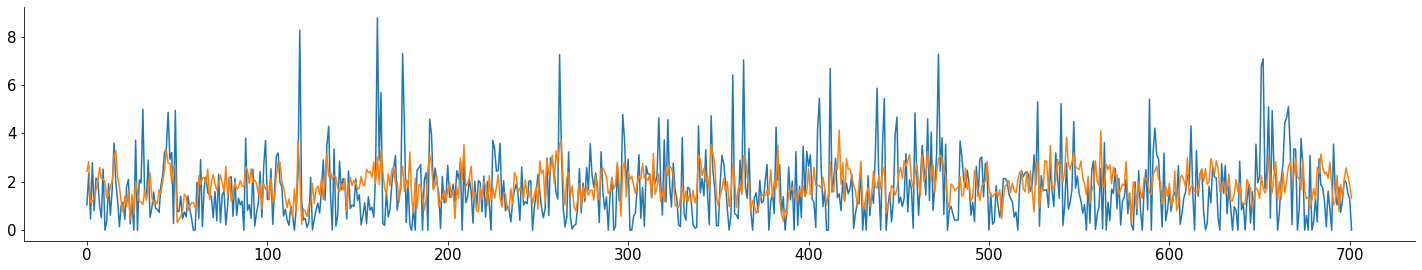

In [51]:
plt.plot(x2_valid[7,:,0].cpu().detach().numpy())
plt.plot(test[7,:,0].cpu().detach().numpy())

## Testing neurons from same layer

In [41]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[n_neurs:2*n_neurs,:]).unsqueeze(2).to(device).float())

In [43]:
test.shape

torch.Size([1131, 3510, 1])

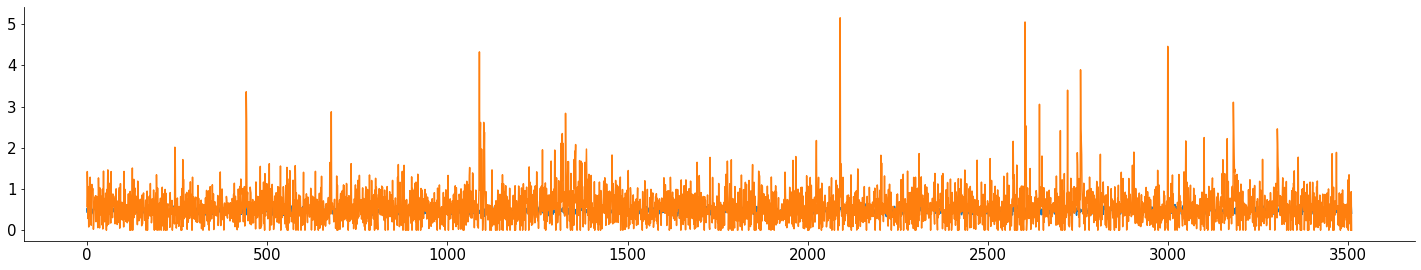

In [47]:
n_n = 15
plt.plot(test[n_n,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[n_neurs + n_n,:])

## Testing neurons from another layer (#9)

In [ ]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[10000:10100,:]).unsqueeze(2).to(device).float())

In [ ]:
plt.plot(test[10,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[10010,:])

# Training 9 Networks 
Each Network corresponds to a different layer in V1

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 10000
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

    